[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MikeS96/cv_dl/blob/main/week5/CVDL_CONV_REG_V2.ipynb)

In [ ]:
#Esta es la manera de trabajar con TPU, sin embargo intenten solo usar GPU
"""import os
try:
  dispositivo = os.environ['COLAB_TPU_ADDR']
  TPU_ADD= 'grpc://'+ dispositivo
  print('encontro una TPU en: {}'.format(TPU_ADD))
except KeyError:
  print('No encontre ninguna TPU') """

"import os\ntry:\n  dispositivo = os.environ['COLAB_TPU_ADDR']\n  TPU_ADD= 'grpc://'+ dispositivo\n  print('encontro una TPU en: {}'.format(TPU_ADD))\nexcept KeyError:\n  print('No encontre ninguna TPU') "

**REGULARIZACION**



**Creando una primera CNN usando python, Tensorflow y Keras.
Paso 1. Cargar las librerias básicas: numpy, Tensorflow, Keras. Cargaremos tambien el dataset de ejemplo mnist.**




In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as LK #Esta clase me permite encapsular los parametros
                                     #de la capa y la transformación I/O    
import tensorflow.keras.models as MK #Esta clase me sirve para agrupar capas como un objeto.

from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator



cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test,y_test)= cifar10.load_data() #Este dataset ya viene dividido en train y test.


170500096/170498071 [==============================] - 2s 0us/step


**Imprimamos los tamaños de los datasets tanto de sus datos como de las etiquetas.**
Al imprimirlo nos damos cuenta que el conjunto de datos de ***train*** es de 60 mil, mientras el de ***test*** es de 10 mil. Las imagenes son en escala de grises y sus tamaños de 28x28 

In [ ]:
print('Train imagessize=%s, labelsize=%s' %(x_train.shape, y_train.shape)) #Forma antigua de imprimir con formato en python
print('Test imagessize=%s, labelsize=%s' %(x_test.shape, y_test.shape))

Train imagessize=(50000, 32, 32, 3), labelsize=(50000, 1)
Test imagessize=(10000, 32, 32, 3), labelsize=(10000, 1)


**Miremos que imagenes hay dentro del dataset y como son las etiquetas**

https://www.cs.toronto.edu/~kriz/cifar.html

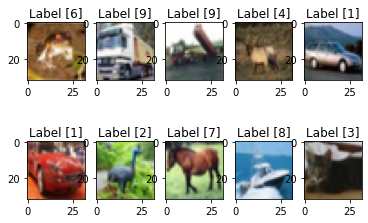

In [ ]:

from matplotlib import pyplot as plt
for i in range(10): #Primeras 5 imagenes
  plt.subplot(2,5,i+1)
  plt.imshow(x_train[i])
  plt.gca().set_title('Label ' + str(y_train[i])) #Podemos ver que los labels son enteros
                                                  #Muchas veces se usa el one-hot encoded
plt.show()

**Normalizacion de 0 a 1**

La idea de la normalización es colocar todos los datos en la misma escala. Aqui se usará la técnica más sencilla que consiste en normalizar entre 0 y 1.

In [ ]:

#Ya que van aser valores entre 0 y 1, estos seran flotantes. Las imagenes son UINT8
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
x_train, x_test = (x_train-x_train.min())/(x_train.max()-x_train.min()), (x_test-x_test.min())/(x_test.max()-x_test.min()) #Normalizando
#x_train, x_test = x_train / 255.0, x_test / 255.0 #Normalizando


**Creación de la ConvNet**
En esta oportunidad nos basaremos en la VGG de Simonyan y Zisserman ganadores del ImageNet Challenge 2014.

https://arxiv.org/pdf/1409.1556.pdf

https://neurohive.io/en/popular-networks/vgg16/


Hagamos un modelo con un solo bloque: 2 capas convolucionales y un Max Pooling.
Vamos a dar un parametro de mas a las capas convolucionales que es el tipo de inicializador.
Hay 2 tipos bien definidos de inicilaizadores: los que usan distribucion uniforme y los que utilizan distibucion gaussiana. 
https://faroit.com/keras-docs/2.0.6/initializers/
A pesar de los estudios realizados, no parece existir una razón de peso para inclinarse por uno o por otro.
Nos basaremos en el trabajo de  Kaiming He (2015) quien asegura que:
"*Recent deep CNNs are mostly initialized by random weights drawn from Gaussian distributions*"

In [ ]:
from keras.optimizers import SGD

In [ ]:
def crear_modelo():
  inputs = LK.Input(shape=(32,32,3)) #Imagesnes de entrada a color
  conv1 = LK.Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(inputs) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  conv2 = LK.Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(conv1) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  pool1 = LK.MaxPool2D((2,2),(2,2))(conv2) #Maxpool f=2, s=2
  #drop1 = LK.Droput(0.25)(pool1)
  conv3 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(pool1) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  conv4 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(conv3) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  pool2 = LK.MaxPool2D((2,2),(2,2))(conv4) #Maxpool f=2, s=2
  #drop2 = LK.Droput(0.25)(pool2)
  conv5 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(pool2) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  conv6 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(conv5) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  pool3 = LK.MaxPool2D((2,2),(2,2))(conv6) #Maxpool f=2, s=2
  #drop3 = LK.Droput(0.25)(pool3)
  flat =  LK.Flatten()(pool3) #aplanando la salida de la capa oculta
  FC3 = LK.Dense(128,activation='relu', kernel_initializer='he_normal')(flat)
  outputs = LK.Dense(10,activation='softmax')(FC3) #Capa de salida con 10 nodes por ser un problema de 
                                                  #clasificación multiclase. Función de activacion:softmax
  return MK.Model(inputs,outputs) #Volviendolo un objeto.
#model.summary() #Imprime nuestro modelo como visto en clase.
#Antes de empezar a entrenar, vamos a definir el optimizador: En este caso vamos a usar SGD con LR=0.001 y Momentum: 0.9)
#La función de pérdida: sparse_categorical_crossentropy, ya que nuestras etiquetas son numero enteros.
# Si nuestras etiquetas hubiesen sido one hot encoded, debiamos haber usado categorical_crossentropy
#La metrica de evaluación será en este caso el accuracy


In [ ]:
#De nuevo estas lineas hacen parte del manejo con TPU, intentar no usarlas
"""resolv = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolv)
tf.tpu.experimental.initialize_tpu_system(resolv)
print('Dispositivos:',tf.config.list_logical_devices('TPU'))
estrategia = tf.distribute.TPUStrategy(resolv)
"""

"resolv = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])\ntf.config.experimental_connect_to_cluster(resolv)\ntf.tpu.experimental.initialize_tpu_system(resolv)\nprint('Dispositivos:',tf.config.list_logical_devices('TPU'))\nestrategia = tf.distribute.TPUStrategy(resolv)\n"

In [ ]:
"""optimo= SGD(lr=0.001, momentum=0.9)
with estrategia.scope():
  model = crear_modelo()
  model.compile(optimizer=optimo, loss='sparse_categorical_crossentropy',metrics=['accuracy'] )
model.summary()
"""
#Cambiamos nuevamente para usar solo la GPU
optimo= SGD(lr=0.001, momentum=0.9)
model = crear_modelo()
model.compile(optimizer=optimo, loss='sparse_categorical_crossentropy',metrics=['accuracy'] )
model.summary()

KeyboardInterrupt: ignored

**Evalución del modelo**
Guardaremos la evaluación en una variable llamada ***history***

In [ ]:
history =model.fit(x_train,y_train, epochs=50, batch_size=64,validation_data=(x_test, y_test), verbose=1)
loss,acc= model.evaluate(x_test,y_test,verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss,acc) ) #Forma moderna de imprimir con formato en python


Epoch 1/50
782/782 [==============================] - 44s 19ms/step - loss: 1.9908 - accuracy: 0.2644 - val_loss: 1.5021 - val_accuracy: 0.4575
Epoch 2/50
782/782 [==============================] - 14s 18ms/step - loss: 1.4644 - accuracy: 0.4722 - val_loss: 1.3123 - val_accuracy: 0.5266
Epoch 3/50
782/782 [==============================] - 14s 18ms/step - loss: 1.3070 - accuracy: 0.5308 - val_loss: 1.2128 - val_accuracy: 0.5637
Epoch 4/50
782/782 [==============================] - 14s 18ms/step - loss: 1.1877 - accuracy: 0.5796 - val_loss: 1.1776 - val_accuracy: 0.5789
Epoch 5/50
782/782 [==============================] - 14s 18ms/step - loss: 1.0941 - accuracy: 0.6125 - val_loss: 1.0887 - val_accuracy: 0.6200
Epoch 6/50
782/782 [==============================] - 14s 18ms/step - loss: 1.0087 - accuracy: 0.6420 - val_loss: 0.9969 - val_accuracy: 0.6467
Epoch 7/50
782/782 [==============================] - 14s 18ms/step - loss: 0.9405 - accuracy: 0.6666 - val_loss: 0.9835 - val_accuracy:

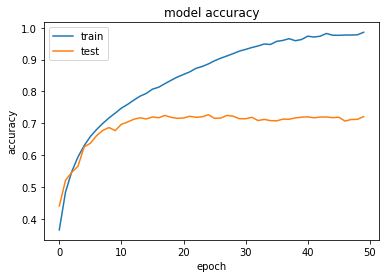

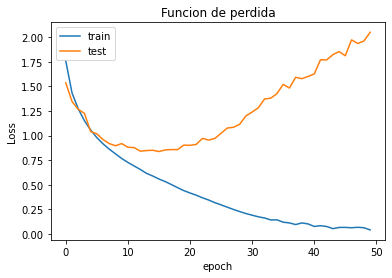

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Como pueden observar, sin el uso de un metodo de regularizacion, se observa el caso tipico de overfitting donde la curva de LOSS VALIDATION presenta una forma de "U" ascendente.

<font color='blue'> **1ER METODO DE REGULARIZACION: DROPOUT.**</font>
Quite los comentarios a las lineas de dropout, complete el codigo donde aparezcan los interrogantes y vuelva a entrenar la ConvNet.

In [ ]:
tf.keras.backend.clear_session

<function tensorflow.python.keras.backend.clear_session>

In [ ]:
def crear_modelo():
  inputs = LK.Input(shape=(32,32,3)) #Imagesnes de entrada a color
  conv1 = LK.Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(inputs) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  conv2 = LK.Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(conv1) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  pool1 = LK.MaxPool2D((2,2),(2,2))(conv2) #Maxpool f=2, s=2
  drop1 = LK.Dropout(0.25)(pool1)
  conv3 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(drop1) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  conv4 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(conv3) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  pool2 = LK.MaxPool2D((2,2),(2,2))(conv4) #Maxpool f=2, s=2
  drop2 = LK.Dropout(0.25)(pool2)
  conv5 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(drop2) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  conv6 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(conv5) #capa de convolución: 32 filtros, f=3, p=1 y a=relu
  pool3 = LK.MaxPool2D((2,2),(2,2))(conv6) #Maxpool f=2, s=2
  drop3 = LK.Dropout(0.25)(pool3)
  flat =  LK.Flatten()(drop3) #aplanando la salida de la capa oculta
  FC3 = LK.Dense(128,activation='relu', kernel_initializer='he_normal')(flat)
  outputs = LK.Dense(10,activation='softmax')(FC3) #Capa de salida con 10 nodes por ser un problema de 
                                                  #clasificación multiclase. Función de activacion:softmax
  return MK.Model(inputs,outputs) #Volviendolo un objeto.
#model.summary() #Imprime nuestro modelo como visto en clase.
#Antes de empezar a entrenar, vamos a definir el optimizador: En este caso vamos a usar SGD con LR=0.001 y Momentum: 0.9)
#La función de pérdida: sparse_categorical_crossentropy, ya que nuestras etiquetas son numero enteros.
# Si nuestras etiquetas hubiesen sido one hot encoded, debiamos haber usado categorical_crossentropy
#La metrica de evaluación será en este caso el accuracy


In [ ]:
optimo= SGD(lr=0.001, momentum=0.9)
model = crear_modelo()
model.compile(optimizer=optimo, loss='sparse_categorical_crossentropy',metrics=['accuracy'] )
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        3692

**Evalución del modelo**
Guardaremos la evaluación en una variable llamada ***history***

In [ ]:
history =model.fit(x_train,y_train, epochs=50, batch_size=64,validation_data=(x_test, y_test), verbose=1)
loss,acc= model.evaluate(x_test,y_test,verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss,acc) ) #Forma moderna de imprimir con formato en python


Epoch 1/50
782/782 [==============================] - 16s 19ms/step - loss: 2.1827 - accuracy: 0.1887 - val_loss: 1.6761 - val_accuracy: 0.3852
Epoch 2/50
782/782 [==============================] - 15s 19ms/step - loss: 1.6695 - accuracy: 0.3784 - val_loss: 1.5060 - val_accuracy: 0.4478
Epoch 3/50
782/782 [==============================] - 15s 19ms/step - loss: 1.5256 - accuracy: 0.4384 - val_loss: 1.4003 - val_accuracy: 0.4925
Epoch 4/50
782/782 [==============================] - 15s 19ms/step - loss: 1.4379 - accuracy: 0.4722 - val_loss: 1.3831 - val_accuracy: 0.4928
Epoch 5/50
782/782 [==============================] - 15s 19ms/step - loss: 1.3569 - accuracy: 0.5066 - val_loss: 1.2638 - val_accuracy: 0.5419
Epoch 6/50
782/782 [==============================] - 15s 19ms/step - loss: 1.2867 - accuracy: 0.5299 - val_loss: 1.2025 - val_accuracy: 0.5678
Epoch 7/50
782/782 [==============================] - 15s 19ms/step - loss: 1.2286 - accuracy: 0.5565 - val_loss: 1.1355 - val_accuracy:

<font color='blue'>**Grafique las curvas de loss y accuracy** </font>
 ¿Mejoró? ¿Cree que hay un nuevo problema? Si existe un nuevo problema ¿Como lo podría solucionar?

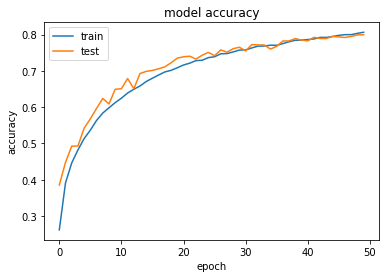

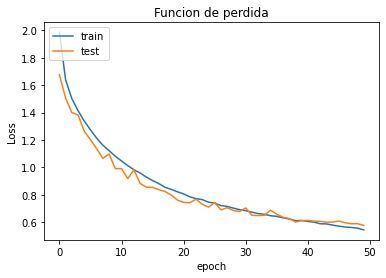

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<font color='blue'> **2DO METODO DE REGULARIZACION: Data augmentation**</font>
Este metodo consiste en adquirir nuevas imagenes de entrenamiento, usando las imagenes dadas y realizandoles cambios logicos, como por ejemplo: rotación, zoom, escalamiento, saltos, etc.
A continuación usted encontrara diferentes operaciones individuales, con el fin de que logre intuir como se manejan algunas de estas operaciones  sobre una imagen. Lo primero que debe hacer es bajar un imagen cualquiera de internet (les propongo que sea una rana, por la logica que tiene de ser util realizarle todas las diferentes operaciones). Observe como se parametriza cada operación, intente hacer cambios en estos parámetros que le permitan tener certeza de que comprende completamente.

<font color='red'> **A. Data augmentation : Operacion de salto a lo ancho**</font>

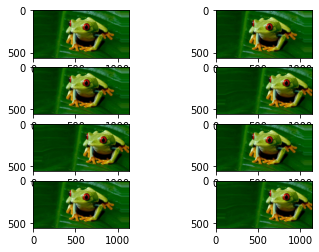

In [ ]:
#Creamos una instancia del generador de datos.
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot as plt

datagen = ImageDataGenerator()
im = load_img('rana.jpg') #cargamos una imagen
im_array = img_to_array(im) #convertimos la imagen a un arreglo de numpy
muestras = expand_dims(im_array, 0) # expandimos la dimension a una muestra

#Ejemplo creando saltos en el ancho de la imagen
datagen = ImageDataGenerator(width_shift_range=[-100,100])
itera = datagen.flow(muestras, batch_size=1)
#Generamos las nuevas muestras
for i in range(8):
  batch = itera.next()
  new_im = batch[0].astype('uint8')
  plt.subplot(4,2,i+1)
  plt.imshow(new_im)
plt.show()



<font color='red'> **B. Data augmentation : Operacion de salto a lo alto**</font>

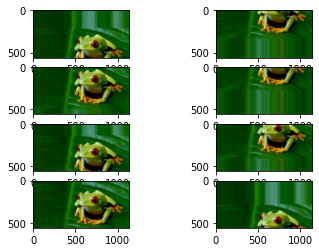

In [ ]:
#Ejemplo creando saltos en el alto de la imagen
#fill_mode  constant reflect wrap nearest
datagen = ImageDataGenerator(height_shift_range=0.5,fill_mode='nearest')
itera = datagen.flow(muestras, batch_size=1)
#Generamos las nuevas muestras
for i in range(8):
  batch = itera.next()
  new_im = batch[0].astype('uint8')
  plt.subplot(4,2,i+1)
  plt.imshow(new_im)
plt.show()

<font color='red'> **C. Data augmentation : Operacion de salto a lo ancho y a lo alto**</font>

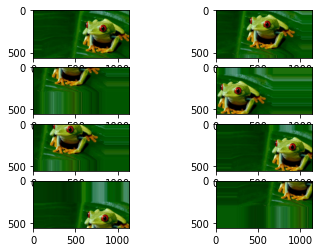

In [ ]:
#Ejemplo creando giros horizontales o verticales
datagen = ImageDataGenerator(width_shift_range = 0.5, height_shift_range=0.5, fill_mode='nearest')
itera = datagen.flow(muestras, batch_size=1)
#Generamos las nuevas muestras
for i in range(8):
  batch = itera.next()
  new_im = batch[0].astype('uint8')
  plt.subplot(4,2,i+1)
  plt.imshow(new_im)
plt.show()

<font color='red'> **D. Data augmentation : Operacion de rotacion**</font>

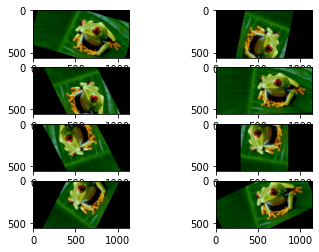

In [ ]:
#Ejemplo creando rotaciones  de la imagen
datagen = ImageDataGenerator(rotation_range=180, fill_mode='constant')
itera = datagen.flow(muestras, batch_size=1)
#Generamos las nuevas muestras
for i in range(8):
  batch = itera.next()
  new_im = batch[0].astype('uint8')
  plt.subplot(4,2,i+1)
  plt.imshow(new_im)
plt.show()

<font color='red'> **E. Data augmentation : Operacion de cambio de brillo**</font>

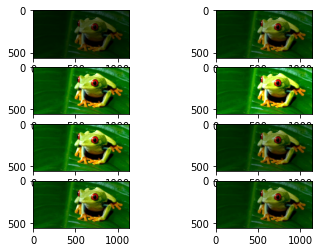

In [ ]:
#Ejemplo cambiando el brillo de la imagen
#Valores entre 0 y1 oscurecen la imagen
#Valores mayores que 1 ilumina la imagen
datagen = ImageDataGenerator(brightness_range=[0.4, 1.5])
itera = datagen.flow(muestras, batch_size=1)
#Generamos las nuevas muestras
for i in range(8):
  batch = itera.next()
  new_im = batch[0].astype('uint8')
  plt.subplot(4,2,i+1)
  plt.imshow(new_im)
plt.show()

<font color='red'> **F. Data augmentation : Operacion de zoom**</font>

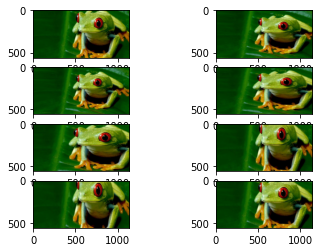

In [ ]:
#Ejemplo creando zoom  de la imagen
#el rango será 1-valor, 1+valor  zoom in   zoom out
datagen = ImageDataGenerator(zoom_range=[0.5, 1])
itera = datagen.flow(muestras, batch_size=1)
#Generamos las nuevas muestras
for i in range(8):
  batch = itera.next()
  new_im = batch[0].astype('uint8')
  plt.subplot(4,2,i+1)
  plt.imshow(new_im)
plt.show()

In [ ]:
tf.keras.backend.clear_session

<function tensorflow.python.keras.backend.clear_session>

<font color='blue'> **Data augmentation sobre nuestro dataset y nuestro modelo**</font>
Complete el codigo del nuevo modelo el cual usara data augmentation. Este código es pasado a ustedes porque aparece tambien incluido un parametro de regularizacion del kernel. El cual será explicado en el próximo encuentro.

In [ ]:
from keras.optimizers import SGD
from keras.regularizers import l2

inputs = LK.Input(shape=(32, 32, 3)) #Imagesnes de entrada a color
conv1 = LK.Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(inputs) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
conv2 = LK.Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(conv1) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
pool1 = LK.MaxPool2D((2,2),(2,2))(conv2) #Maxpool f=2, s=2
#drop1 = LK.Dropout(0.25)(pool1)
conv3 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(pool1) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
conv4 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(conv3) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
pool2 = LK.MaxPool2D((2,2),(2,2))(conv4) #Maxpool f=2, s=2
#drop2 = LK.Dropout(0.25)(¿¿)
conv5 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(pool2) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
conv6 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(conv5) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
pool3 = LK.MaxPool2D((2,2),(2,2))(conv6) #Maxpool f=2, s=2
#drop3 = LK.Dropout(0.25)(¿¿)
flat =  LK.Flatten()(pool3) #aplanando la salida de la capa oculta
FC3 = LK.Dense(128,activation='relu', kernel_initializer='he_normal')(flat)
#drop4 = LK.Dropout(0.25)(??)
outputs = LK.Dense(10,activation='softmax')(FC3) #Capa de salida con 10 nodes por ser un problema de 
                                                  #clasificación multiclase. Función de activacion:softmax
model = MK.Model(inputs ,outputs) #Volviendolo un objeto.
model.summary() #Imprime nuestro modelo como visto en clase.
#Antes de empezar a entrenar, vamos a definir el optimizador: En este caso vamos a usar SGD con LR=0.001 y Momentum: 0.9)
#La función de pérdida: sparse_categorical_crossentropy, ya que nuestras etiquetas son numero enteros.
# Si nuestras etiquetas hubiesen sido one hot encoded, debiamos haber usado categorical_crossentropy
#La metrica de evaluación será en este caso el accuracy
optimo= SGD(lr=0.001, momentum=0.9) # categorical_crossentropy
#model.compile(optimizer=optimo, loss='sparse_categorical_crossentropy',metrics=['accuracy'] )
model.compile(optimizer=optimo, loss='categorical_crossentropy',metrics=['accuracy'] )

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 8, 8, 64)          0  

<font color='blue'> **Data augmentation :**</font>
Vamos a aumentar el numero de imagenes en el entrenamiento usando el ImageDataGenerator. Con lo aprendido anteriormente, use al menos 3 diferentes operaciones que sean logicas con respecto al dataset estudiado. Complete el codigo

In [ ]:
from keras.utils import np_utils
#from keras.preprocessing.image import ImageDataGenerator
#datagen = ImageDataGenerator(width_shift_range = 0.5, height_shift_range=0.5, rotation_range=30, zoom_range=[0.5, 1], fill_mode='nearest')
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
y_train_cat = np_utils.to_categorical(y_train, 10)
y_test_cat = np_utils.to_categorical(y_test, 10)
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1)
test_datagen = ImageDataGenerator()
datagen.fit(x_train)
iterator = datagen.flow(x_train, y_train_cat, batch_size=64)
iterator_test = datagen.flow(x_test, y_test_cat, batch_size=64)
muestras = x_train.shape[0] // 64 
# fits the model on batches with real-time data augmentation:
history = model.fit(iterator, steps_per_epoch = muestras, epochs=50, verbose = 1, validation_data = iterator_test)
loss,acc= model.evaluate(x_test, y_test, verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss,acc) ) 

Epoch 1/50
781/781 [==============================] - 28s 35ms/step - loss: 2.0002 - accuracy: 0.2689 - val_loss: 1.6555 - val_accuracy: 0.4129
Epoch 2/50
781/781 [==============================] - 27s 35ms/step - loss: 1.5619 - accuracy: 0.4349 - val_loss: 1.4539 - val_accuracy: 0.4817
Epoch 3/50
781/781 [==============================] - 27s 35ms/step - loss: 1.4345 - accuracy: 0.4837 - val_loss: 1.3933 - val_accuracy: 0.4971
Epoch 4/50
781/781 [==============================] - 28s 36ms/step - loss: 1.3399 - accuracy: 0.5197 - val_loss: 1.2968 - val_accuracy: 0.5342
Epoch 5/50
781/781 [==============================] - 28s 36ms/step - loss: 1.2770 - accuracy: 0.5428 - val_loss: 1.2130 - val_accuracy: 0.5659
Epoch 6/50
781/781 [==============================] - 27s 35ms/step - loss: 1.2115 - accuracy: 0.5687 - val_loss: 1.1767 - val_accuracy: 0.5841
Epoch 7/50
781/781 [==============================] - 27s 35ms/step - loss: 1.1530 - accuracy: 0.5890 - val_loss: 1.1407 - val_accuracy:

**Visualización**
Graficaremos el ***accuracy*** tanto para los datos de ***train*** como para los datos de ***test***.

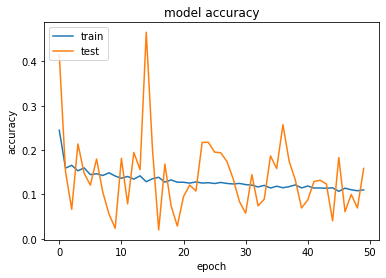

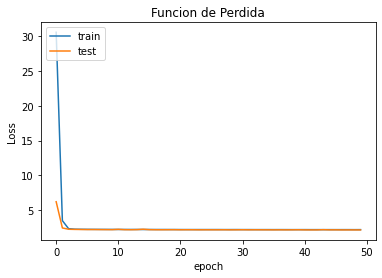

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de Perdida')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Salvando el modelo**

In [ ]:
model.save('vggown.h5')

## USing L2 Regularization

In [ ]:
tf.keras.backend.clear_session

<function tensorflow.python.keras.backend.clear_session>

In [ ]:
from keras.optimizers import SGD
from keras.regularizers import l2

inputs = LK.Input(shape=(32, 32, 3)) #Imagesnes de entrada a color
conv1 = LK.Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', activation='relu', kernel_regularizer=l2(0.01))(inputs) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
conv2 = LK.Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', activation='relu',kernel_regularizer=l2(0.01))(conv1) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
pool1 = LK.MaxPool2D((2,2),(2,2))(conv2) #Maxpool f=2, s=2
#drop1 = LK.Dropout(0.25)(pool1)
conv3 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu',kernel_regularizer=l2(0.01))(pool1) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
conv4 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu',kernel_regularizer=l2(0.01))(conv3) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
pool2 = LK.MaxPool2D((2,2),(2,2))(conv4) #Maxpool f=2, s=2
#drop2 = LK.Dropout(0.25)(¿¿)
conv5 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu',kernel_regularizer=l2(0.01))(pool2) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
conv6 = LK.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal', activation='relu',kernel_regularizer=l2(0.01))(conv5) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
pool3 = LK.MaxPool2D((2,2),(2,2))(conv6) #Maxpool f=2, s=2
#drop3 = LK.Dropout(0.25)(¿¿)
flat =  LK.Flatten()(pool3) #aplanando la salida de la capa oculta
FC3 = LK.Dense(128,activation='relu', kernel_initializer='he_normal',kernel_regularizer=l2(0.01) )(flat)
#drop4 = LK.Dropout(0.25)(??)
outputs = LK.Dense(10,activation='softmax')(FC3) #Capa de salida con 10 nodes por ser un problema de 
                                                  #clasificación multiclase. Función de activacion:softmax
model = MK.Model(inputs ,outputs) #Volviendolo un objeto.
model.summary() #Imprime nuestro modelo como visto en clase.
#Antes de empezar a entrenar, vamos a definir el optimizador: En este caso vamos a usar SGD con LR=0.001 y Momentum: 0.9)
#La función de pérdida: sparse_categorical_crossentropy, ya que nuestras etiquetas son numero enteros.
# Si nuestras etiquetas hubiesen sido one hot encoded, debiamos haber usado categorical_crossentropy
#La metrica de evaluación será en este caso el accuracy
optimo= SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=optimo, loss='sparse_categorical_crossentropy',metrics=['accuracy'] )

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0   

In [ ]:
history =model.fit(x_train,y_train, epochs=50, batch_size=64,validation_data=(x_test, y_test), verbose=1)
loss,acc= model.evaluate(x_test,y_test,verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss,acc) ) #Forma moderna de imprimir con formato en python

Epoch 1/50
782/782 [==============================] - 7s 8ms/step - loss: 2.9248 - accuracy: 0.2617 - val_loss: 2.4200 - val_accuracy: 0.4384
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 2.3677 - accuracy: 0.4545 - val_loss: 2.2260 - val_accuracy: 0.5029
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 2.1684 - accuracy: 0.5280 - val_loss: 2.0686 - val_accuracy: 0.5642
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 2.0204 - accuracy: 0.5779 - val_loss: 1.9674 - val_accuracy: 0.5892
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 1.9079 - accuracy: 0.6137 - val_loss: 1.8964 - val_accuracy: 0.6087
Epoch 6/50
782/782 [==============================] - 6s 8ms/step - loss: 1.8034 - accuracy: 0.6460 - val_loss: 1.8378 - val_accuracy: 0.6290
Epoch 7/50
782/782 [==============================] - 6s 7ms/step - loss: 1.7297 - accuracy: 0.6648 - val_loss: 1.7739 - val_accuracy: 0.6470
Epoch 

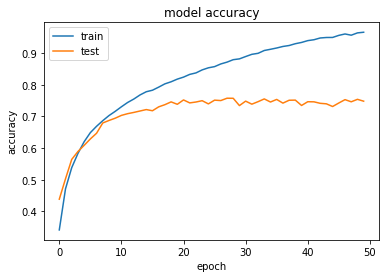

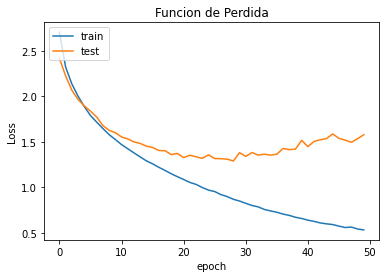

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de Perdida')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('vgg16_l2.h5')
from keras.models import load_model
modelo= load_model('vgg16_l2.h5')